In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

2023-03-08 11:56:44.324976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 11:56:44.436508: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-08 11:56:44.442155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 11:56:44.442174: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
import os
import cv2
X = []
for file in os.listdir("clean"):
    X.append(cv2.imread("clean/"+file, cv2.THRESH_BINARY))
X = np.array(X)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, X)

In [4]:
print(X_train.shape)
print(X_test.shape)

Training set shape:  (1491, 60, 60)
Testing set shape:  (497, 60, 60)


In [5]:
def sp_noise(image, prob):
    output = image.copy()
    if len(image.shape) == 2:
        black = 0
        white = 1
    probs = np.random.random(output.shape[:2])
    # output[probs < (prob / 2)] = black
    output[probs > 1 - (prob / 2)] = white
    return output

In [6]:
# Rescale images to range [0, 1] to facilitate model training.
X_train = X_train / 255
X_test = X_test / 255

X_train_noisy = []
X_test_noisy = []

# Apply noise to all images from the training set.
noise_factor = 0.4
for image in X_train:
    noisy_image = sp_noise(image, noise_factor)
    # Clip to make normally distributed array go back to range [0, 1].
    noisy_image = np.clip(noisy_image, 0, 1)
    X_train_noisy.append(noisy_image)

# Apply noise to all images from the testing set.
noise_factor = 0.4
for image in X_test:
    noisy_image = sp_noise(image, noise_factor)
    noisy_image = np.clip(noisy_image, 0, 1)
    X_test_noisy.append(noisy_image)

X_train_noisy = np.array(X_train_noisy)
X_test_noisy = np.array(X_test_noisy)

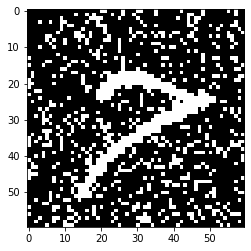

In [7]:
plt.imshow(X_train_noisy[0], cmap=plt.cm.gray)

In [8]:
autoencoder = keras.models.Sequential()

autoencoder.add(keras.layers.Conv2D(32, (3, 3), padding='same',
                                    input_shape=(60, 60, 1)))
autoencoder.add(keras.layers.MaxPooling2D((2, 2), padding='same'))

autoencoder.add(keras.layers.Conv2D(16, (3, 3), padding='same'))
autoencoder.add(keras.layers.MaxPooling2D((2, 2), padding='same'))

autoencoder.add(keras.layers.Conv2D(8, (3, 3), padding='same'))

autoencoder.add(keras.layers.UpSampling2D((2, 2)))
autoencoder.add(keras.layers.Conv2DTranspose(16, (3, 3), padding='same'))

autoencoder.add(keras.layers.UpSampling2D((2, 2)))
autoencoder.add(keras.layers.Conv2DTranspose(1, (3, 3), padding='same',
                                    activation='sigmoid'))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 8)         1160      
                                                                 
 up_sampling2d (UpSampling2D  (None, 30, 30, 8)        0

2023-03-08 11:56:49.518910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lord/miniconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-08 11:56:49.519219: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 11:56:49.519255: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Linux): /proc/driver/nvidia/version does not exist
2023-03-08 11:56:49.520043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
autoencoder.compile(keras.optimizers.Adam(learning_rate=0.001),
                    loss='binary_crossentropy')


batch_size = X_train_noisy.shape[0] // 200


early_stopping_cb = keras.callbacks.EarlyStopping(min_delta=0.0001,
                                                  patience=10,
                                                  restore_best_weights=True)
lr_reducer_cb = keras.callbacks.ReduceLROnPlateau(patience=3,
                                                  min_lr=0.0001)


autoencoder.fit(X_train_noisy.reshape(-1, 60, 60, 1),
                X_train.reshape(-1, 60, 60, 1),
                batch_size=batch_size,
                epochs=50,
                callbacks=[early_stopping_cb, lr_reducer_cb],
                validation_split=0.15)

Epoch 1/50
181/181 [==============================] - 3s 16ms/step - loss: 0.0990 - val_loss: 0.0393 - lr: 0.0010
Epoch 2/50
181/181 [==============================] - 3s 14ms/step - loss: 0.0327 - val_loss: 0.0291 - lr: 0.0010
Epoch 3/50
181/181 [==============================] - 3s 15ms/step - loss: 0.0269 - val_loss: 0.0257 - lr: 0.0010
Epoch 4/50
181/181 [==============================] - 3s 14ms/step - loss: 0.0242 - val_loss: 0.0239 - lr: 0.0010
Epoch 5/50
181/181 [==============================] - 3s 15ms/step - loss: 0.0226 - val_loss: 0.0229 - lr: 0.0010
Epoch 6/50
181/181 [==============================] - 3s 15ms/step - loss: 0.0214 - val_loss: 0.0218 - lr: 0.0010
Epoch 7/50
181/181 [==============================] - 3s 14ms/step - loss: 0.0206 - val_loss: 0.0210 - lr: 0.0010
Epoch 8/50
181/181 [==============================] - 3s 15ms/step - loss: 0.0199 - val_loss: 0.0206 - lr: 0.0010
Epoch 9/50
181/181 [==============================] - 3s 14ms/step - loss: 0.0195 - val_

1/1 [==============================] - 0s 102ms/step


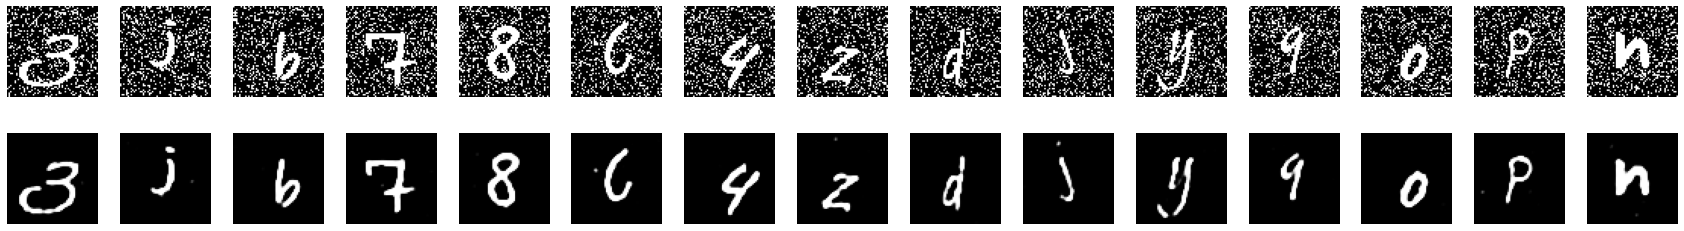

In [10]:

denoised_images = autoencoder.predict(X_test_noisy[:15].reshape(-1, 60, 60, 1))

fig, axes = plt.subplots(nrows=2, ncols=15, figsize=(30, 4))
axes = axes.ravel()


for i in range(15):
    axes[i].imshow(X_test_noisy[i], cmap='gray')
    axes[i].axis('off')

for i in range(15):
    axes[i + 15].imshow(denoised_images[i].reshape(60, 60), cmap='gray')
    axes[i + 15].axis('off')
plt.subplots_adjust(hspace=0.4)

In [34]:
import os
import cv2
X1 = []
X1_name = []
for file in os.listdir("train"):
    X1_name.append(file)
    X1.append(cv2.imread("train/"+file, cv2.THRESH_BINARY))
X1 = np.array(X1)
X1 = X1/255

In [35]:
import os
import cv2
X2 = []
X2_name = []
for file in os.listdir("val"):
    X2_name.append(file)
    X2.append(cv2.imread("val/"+file, cv2.THRESH_BINARY))
X2 = np.array(X2)
X2 = X2/255

1/1 [==============================] - 0s 185ms/step


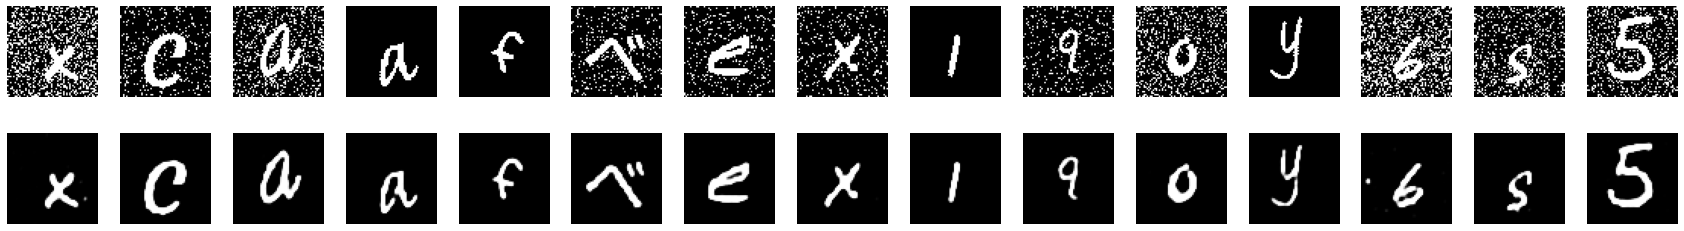

In [36]:
denoised_images = autoencoder.predict(X1[:15].reshape(-1, 60, 60, 1))

fig, axes = plt.subplots(nrows=2, ncols=15, figsize=(30, 4))
axes = axes.ravel()

for i in range(15):
    axes[i].imshow(X1[i], cmap='gray')
    axes[i].axis('off')

for i in range(15):
    axes[i + 15].imshow(denoised_images[i].reshape(60, 60), cmap='gray')
    axes[i + 15].axis('off')
plt.subplots_adjust(hspace=0.4)

In [37]:
denoised_images = autoencoder.predict(X1.reshape(-1, 60, 60, 1))

294/294 [==============================] - 6s 18ms/step


In [38]:
import cv2
i = 0
for file in X1_name:
    denoised = denoised_images[i]
    cv2.imwrite("train_/"+file, denoised*255)
    i += 1

In [39]:
denoised_images = autoencoder.predict(X2.reshape(-1, 60, 60, 1))

35/35 [==============================] - 1s 19ms/step


In [40]:
import cv2
i = 0
for file in X2_name:
    denoised = denoised_images[i]
    cv2.imwrite("val_/"+file, denoised*255)
    i += 1